In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
import matplotlib as mpl
from matplotlib.colors import LogNorm
from matplotlib.colors import Normalize
from scipy.interpolate import interp2d
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from labellines import labelLines
from labellines import labelLine
from PIL import Image

In [2]:
cities_populations = pd.DataFrame(columns=['city', 'population'])
for name in ['miami', 'ma', 'bogota']:
    pd.read_csv(f'confinement/cities3/{name}/Poparea.txt', sep=' ', header=None)

miami 5590269.0
ma 4146213.0
bogota 7129506.0


In [ ]:
populations = pd.read_csv('confinement/cities3/miami/Poparea.txt', sep=' ', header=None, names=['zcta', 'population', 'area'])
OD_matrix = pd.read_csv('confinement/cities3/miami/mobnetwork.txt', sep=' ', header=None, names=['i', 'j', 'weight'])

OD_weights_i = OD_matrix.groupby('i').sum()[['weight']]
OD_matrix = pd.merge(OD_matrix, OD_weights_i, left_on='i', right_index=True, how='left')
OD_matrix['weight'] = OD_matrix['weight_x'] / OD_matrix['weight_y']
OD_matrix = OD_matrix.drop(['weight_x', 'weight_y'], axis=1)

OD_matrix = pd.merge(OD_matrix, populations, left_on='i', right_on='zcta')
OD_matrix['population'] = OD_matrix['population'] * OD_matrix['weight']

OD_matrix.groupby('j').sum()['population'].sort_values(ascending=False).head(30)

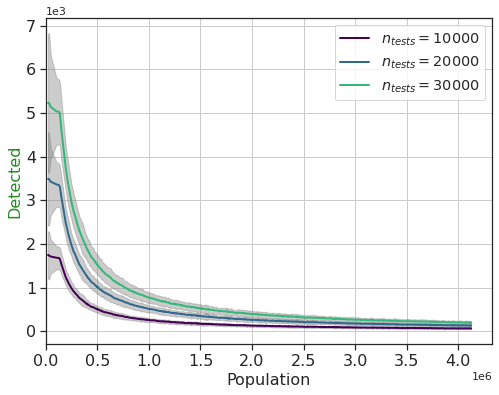

In [2]:
sns.set_theme(style="ticks")

fig,ax = plt.subplots(figsize=(8,6))

label_size = 16
abc_size = 16*1.6

name = 'ma'
betastr = '3,0'
heatmap = pd.read_csv('tests/out/' + name + '_30k_beta_' + betastr +
                        '.txt', sep='\t')

colormap = mpl.colormaps['viridis']

for i,ntests in enumerate([10000, 20000, 30000]):
    data = heatmap[heatmap['tests'] == ntests].copy()
    #rolling average of data
    data['detected'] = data['detected']#.rolling(window=4).mean()
    data['error'] = data['error']#.rolling(window=4).mean()
    color = colormap(i/3)
    ax.plot('population', 'detected', data=data, color=color, lw=2, label = r'$n_{tests} = $' + str(ntests))
    ax.fill_between(x=data['population'], y1=data['detected']+ 1*data['error'], y2=data['detected']-1*data['error'], color='gray', alpha=0.4)

ax.legend(fontsize=label_size*0.9)

ax.set_xlabel('Population', size=label_size)
ax.set_ylabel('Detected', size=label_size, color='forestgreen')
ax.tick_params(labelsize=label_size)
ax.set_xlim(0,)
ax.grid('True')
ax.ticklabel_format(axis='both', style='sci', scilimits=(0,0))

fig.savefig('figures/figs_dec23/Fig3a.svg', bbox_inches='tight', dpi=300)

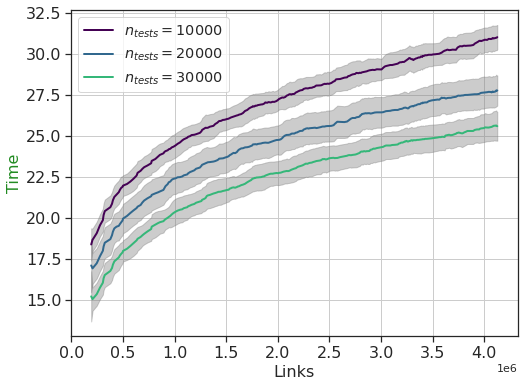

In [26]:
sns.set_theme(style="ticks")

fig,ax = plt.subplots(figsize=(8,6))

label_size = 16
abc_size = 16*1.6

colormap = mpl.colormaps['viridis']

name = 'ma'
betastr = '4,0'
for i,tests in enumerate([10,20,30]):
    heatmap = pd.read_csv('times/out/' + name + f'_{tests}k_60d_beta_' + betastr +
                            '.txt', sep='\t')
    heatmap['time'] = heatmap['time'].rolling(window=4).mean()
    heatmap['time_error'] = heatmap['time_error'].rolling(window=4).mean()
    heatmap['time_error'] = heatmap['time_error']/np.sqrt(23) * 1.96
 

    #rolling average of data
    color = colormap(i/3)
    ax.plot('population', 'time', data=heatmap, color=color, lw=2, label = r'$n_{tests} = $' + str(tests * 1000))
    ax.fill_between(x=heatmap['population'], y1=heatmap['time']+ 1*heatmap['time_error'], y2=heatmap['time']-1*heatmap['time_error'], color='gray', alpha=0.4)

ax.legend(fontsize=label_size*0.9)
ax.set_xlabel('Links', size=label_size)
ax.set_ylabel('Time', size=label_size, color='forestgreen')
ax.tick_params(labelsize=label_size)
ax.set_xlim(0,)
ax.grid('True')
ax.ticklabel_format(axis='x', style='sci', scilimits=(0,0))

fig.savefig('figures/figs_dec23/Fig3b.svg', bbox_inches='tight', dpi=300)

<ipython-input-4-900c3c468cf2>:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('inferno_r')


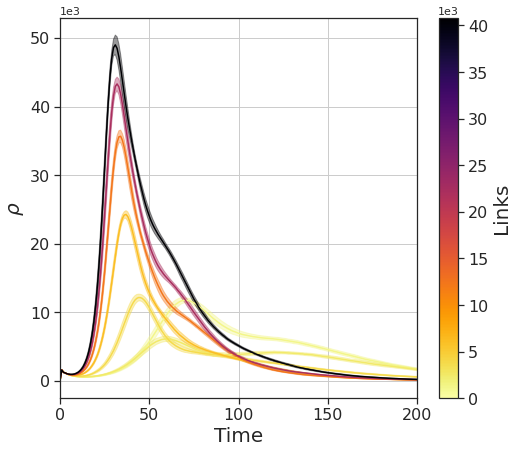

In [4]:
fig,ax = plt.subplots(figsize=(8,7))
label_size = 16
abc_size = 16*1.6

data = pd.read_csv('curves_confinement/out/trajectories/ma_beta_4,0_80k.txt', sep='\t')
data['error'] = data['error'] * np.sqrt(1)

links = data['links'].drop_duplicates()
links = links[links.isin([1237, 2474, 3711, 6185, 12371, 22269, 40826])]

colors = cm.get_cmap('inferno_r')

sns.set_theme(style="ticks")

for l in links:
    ax.plot('time', 'infected', color = colors((l)/(links.max())), data=data[data['links'] == l],
        label=l)
    ax.fill_between(x=data[data['links'] == l]['time'], y1=data[data['links'] == l]['infected']+ 2*data[data['links'] == l]['error'],
        y2=data[data['links'] == l]['infected']-2*data[data['links'] == l]['error'], color=colors((l)/(links.max())), alpha=0.4) 
sm = plt.cm.ScalarMappable(cmap=colors, norm=Normalize(0, links.max()))
cbar=fig.colorbar(sm, ax=ax)


ax.set_xlabel('Time', size=20)
ax.set_ylabel(r'$\rho$', size=20)
ax.tick_params(labelsize=16)
ax.ticklabel_format(axis='y', style='sci', scilimits=(3,3))

cbar.ax.tick_params(labelsize=16)
cbar.ax.set_ylabel('Links', size=20)
cbar.ax.ticklabel_format(axis='y', style='sci', scilimits=(3,3))

ax.grid('True')

ax.set_xlim(0, 200)

fig.savefig('figures/figs_dec23/Fig3c.svg', bbox_inches='tight', dpi=300)

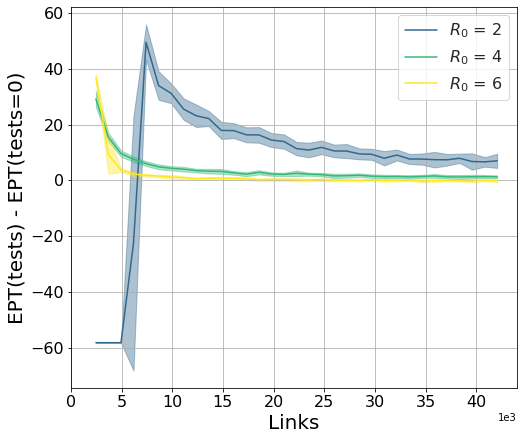

In [51]:
fig,ax = plt.subplots(figsize=(8,7))
label_size = 16
abc_size = 16*1.6

sns.set_theme(style="ticks")

for i,beta in enumerate([2,4,6]):
    data = pd.read_csv(f'curves_confinement/out/EPT/ma_beta_{beta},0_80k.txt', sep='\t')
    EPT_base = pd.read_csv(f'curves_confinement/out/EPT/ma_beta_{beta},0_0k.txt', sep='\t').iloc[0][['EPT', 'error']]
    color = mpl.colormaps['viridis'](beta/6)

    data['EPT'] = data['EPT'].rolling(window=1).mean()
    data['error'] = data['error'].rolling(window=1).mean()

    ax.plot(data['links'], data['EPT'] - EPT_base['EPT'], color = color, label = r'$R_0$ = ' + str(beta))
    ax.fill_between(x=data['links'], y1=data['EPT'] - EPT_base['EPT'] + 2*data['error'],
        y2=data['EPT'] - EPT_base['EPT'] -2*data['error'], color=color, alpha=0.4)

ax.legend(fontsize=16)

ax.set_xlabel('Links', size=20)
ax.set_ylabel('EPT(tests) - EPT(tests=0)', size=20)
ax.tick_params(labelsize=16)
ax.ticklabel_format(axis='x', style='sci', scilimits=(3,3))

ax.grid('True')

ax.set_xlim(0,)
# ax.set_ylim(0,)

fig.savefig('figures/figs_dec23/Fig3d.svg', bbox_inches='tight', dpi=300)

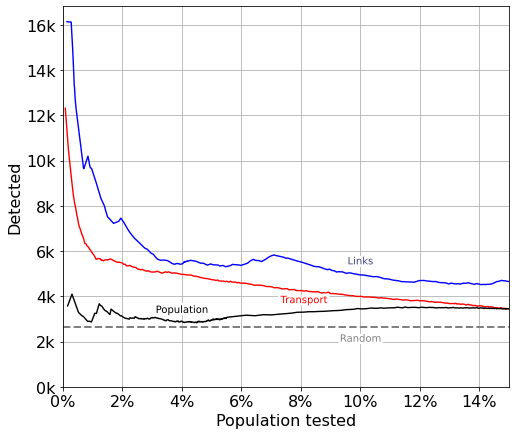

In [12]:
fig,ax = plt.subplots(figsize=(8,7))
label_size = 16
abc_size = 16*1.6

betastr = '8,0'
links = pd.read_csv('times/out/bogota_30k_beta_' + betastr + '.txt', sep='\t')
transport = pd.read_csv('public_transport/times/out/bogota_transport_30k_beta_' + betastr + '.txt', sep='\t')
transport_population = pd.read_csv('public_transport/times/out/population/bogota_transport_30k_beta_' + betastr + '.txt', sep='\t')
lower = links['detected'].iloc[-1]

colormap = mpl.colormaps['viridis_r']

max_days,min_days = 17,9

ax.plot(links['population'], links['detected'], label='Links', c = 'blue', lw=1.4)
ax.plot(transport['population'], transport['detected'], label='Transport', c = 'red', lw=1.4)
ax.plot(transport_population['population'], transport_population['detected'], label='Population', c = 'black', lw=1.4)


total_pop = links['population'].max()

#Plot again the lines with alpha = 0 to set the legend
# ax.plot(links['population'], links['detected'], label='Links', alpha=0)
# ax.plot(transport['population'], transport['detected'], label='Transport', alpha=0)
ax.plot([0,7100000], [lower, lower], label='Random', c = 'grey', lw = 2, linestyle = 'dashed')

labelLine(ax.get_lines()[-4], zorder=2.5, x=0.1*total_pop, outline_width=5, align=False, yoffset=600, color=colormap(0.8))
labelLine(ax.get_lines()[-3], zorder=2.5, x=0.081*total_pop, outline_width=5, align=False, yoffset=-400, color='red')
labelLine(ax.get_lines()[-2], zorder=2.5, x=0.04*total_pop, outline_width=5, align=False, yoffset=500, color='black')
labelLine(ax.get_lines()[-1], zorder=2.5, x=0.1*total_pop, outline_width=5, align=False, yoffset=-500, color='grey')

# ax.legend(fontsize=label_size)


ax.set_xlabel('Population tested', size=label_size)
ax.set_ylabel('Detected', size=label_size)
ax.tick_params(labelsize=label_size)
ax.set_xlim(0, 0.15*total_pop)
ax.set_ylim(0,)

ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x/1000) + 'k'))

percentages = np.array([0,2,4,6,8,10,12,14]) * total_pop / 100
ax.xaxis.set_major_locator(mpl.ticker.FixedLocator(percentages))
ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x/total_pop*100) + '%'))

ax.grid('True')

fig.savefig('figures/figs_dec23/Fig5a.svg', bbox_inches='tight', dpi=300)

/home/paval/.conda/envs/control_conda_env/lib/python3.9/site-packages/labellines/core.py:216: UserWarning: The value at position 0 in `xvals` is outside the range of its associated line (xmin=212593.0, xmax=2169840.0000000005, xval=8235.29411764706). Clipping it into the allowed range.
  warnings.warn(
/home/paval/.conda/envs/control_conda_env/lib/python3.9/site-packages/labellines/core.py:216: UserWarning: The value at position 1 in `xvals` is outside the range of its associated line (xmin=212593.0, xmax=2169840.0000000005, xval=8470.588235294117). Clipping it into the allowed range.
  warnings.warn(
/home/paval/.conda/envs/control_conda_env/lib/python3.9/site-packages/labellines/core.py:216: UserWarning: The value at position 2 in `xvals` is outside the range of its associated line (xmin=212593.0, xmax=2169840.0000000005, xval=8705.882352941177). Clipping it into the allowed range.
  warnings.warn(
/home/paval/.conda/envs/control_conda_env/lib/python3.9/site-packages/labellines/core.

(0.0, 2267702.35)

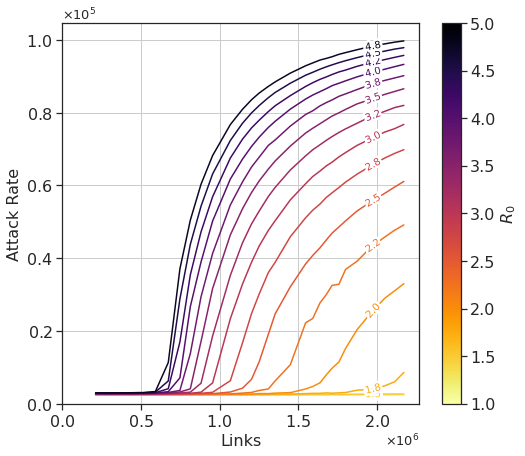

In [52]:
fig,ax1 = plt.subplots(figsize=(8,7))
label_size = 16
abc_size = 16*1.6

heatmap = pd.read_csv('confinement/out/attackRateMap/miami.txt', sep='\t')
# heatmap = heatmap[heatmap['beta'].isin(heatmap['beta'].drop_duplicates()[::2])]
# heatmap = heatmap.drop(heatmap[heatmap['beta'].isin([1,1.4375])].index, axis=0)

pivotTable = pd.pivot_table(data = heatmap, index = 'beta', columns = 'links', values='attackRate')

linearColor = mpl.colormaps['inferno_r']
beta_max,beta_min = 5, 1
for i,val in enumerate(heatmap['beta'].drop_duplicates()):
    links_text = 11472
    color=linearColor((val-beta_min)/(beta_max-beta_min))
    ax1.plot('population', 'attackRate', data=heatmap[heatmap['beta']==val], color=color, label=f'{val:.1f}')
    # ax1.text(links_text, heatmap[(heatmap['beta']==val) & (heatmap['links']==links_text)]['attackRate'].max(),
    #         r'$R_0$ = ' + f'{val:.2f}', color=color, fontsize=8, bbox=dict(facecolor='white', alpha=1, pad=-1), ha='center', va='center')

labelLines(plt.gca().get_lines(), zorder=2.5, xvals=(8000, 12000), outline_width=5, fontsize=10)

# COLORBAR
sm = plt.cm.ScalarMappable(cmap=linearColor, norm=Normalize(vmin=beta_min, vmax=beta_max))
#sm.set_array([])
cbar = fig.colorbar(sm, ax=ax1)

ax1.set_xlabel('Links', size=label_size)
ax1.set_ylabel('Attack Rate', size=label_size)
ax1.tick_params(labelsize=label_size)
ax1.xaxis.set_major_locator(mpl.ticker.MaxNLocator(5))
# ax1.xaxis.set_major_formatter(lambda x, pos: '{:.0f}'.format(x/1000) + 'k')
# ax1.yaxis.set_major_formatter(lambda x, pos: '{:.0f}'.format(x/1000) + 'k')
ax1.ticklabel_format(axis='both', style='sci', scilimits=(0,0), useMathText=True)
ax1.xaxis.offsetText.set_fontsize(label_size*0.8)
ax1.yaxis.offsetText.set_fontsize(label_size*0.8)

cbar.ax.tick_params(labelsize=label_size)
cbar.ax.set_ylabel(r'$R_0$', size=label_size)

ax1.grid('True')
ax1.set_ylim(0,)
ax1.set_xlim(0,)


(0.0, 640868.629)

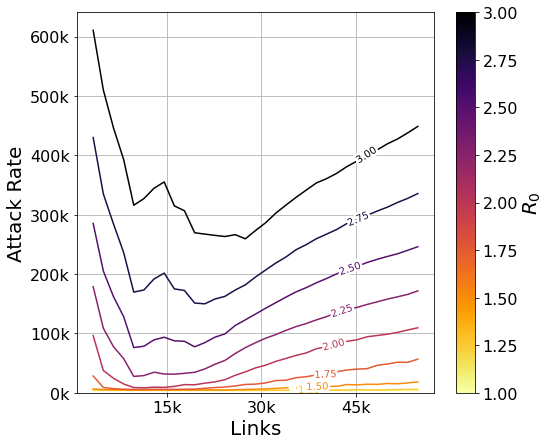

In [6]:
fig,ax = plt.subplots(figsize=(8,7))
label_size = 16
abc_size = 16*1.6

heatmap = pd.read_csv('confinement/out/attackRateMap/bogota.txt', sep='\t', names=['beta','links', 'attackRate', 'error'])

heatmap = heatmap[heatmap['beta'] < 3.0001]
# heatmap = heatmap[heatmap['beta'].isin(heatmap['beta'].drop_duplicates()[::2]) & ((heatmap['beta'] > 1.7) | (heatmap['beta']==1.5))]
# heatmap = heatmap.drop(heatmap[heatmap['beta'].isin([1])].index, axis=0)
pivotTable = pd.pivot_table(data = heatmap, index = 'beta', columns = 'links', values='attackRate')


linearColor = mpl.colormaps['inferno_r']
beta_max,beta_min = 3, 1
for i,val in enumerate(heatmap['beta'].drop_duplicates()):
    links_text = 45203
    color=linearColor((val-beta_min)/(beta_max-beta_min))
    ax.plot('links', 'attackRate', data=heatmap[heatmap['beta']==val], color=color, label=f'{val:.2f}')
    # ax.text(links_text, heatmap[(heatmap['beta']==val) & (heatmap['links']==links_text)]['attackRate'].max(),
    #         r'$R_0$ = ' + f'{val:.2f}', color=color, fontsize=8, bbox=dict(facecolor='white', alpha=1, pad=-1), ha='center', va='center')

labelLines(ax.get_lines(), zorder=2.5, xvals=(35000, 48000), outline_width=5, fontsize=10)

# COLORBAR
sm = plt.cm.ScalarMappable(cmap=linearColor, norm=Normalize(vmin=beta_min, vmax=beta_max))
#sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)

ax.set_xlabel('Links', size=20)
ax.set_ylabel('Attack Rate', size=20)
ax.tick_params(labelsize=16)
ax.xaxis.set_major_formatter(lambda x, pos: '{:.0f}'.format(x/1000) + 'k')
ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(5))
ax.yaxis.set_major_formatter(lambda x, pos: '{:.0f}'.format(x/1000) + 'k')

cbar.ax.tick_params(labelsize=16)
cbar.ax.set_ylabel(r'$R_0$', size=20)

ax.grid('True')

ax.set_ylim(0,)